# Data Processing Pipelines Comparison

<a href="https://colab.research.google.com/github/ericiortega/ids705-phishing-detection/blob/main/notebooks/1_baseline_vs_other_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

## Load Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import string
import seaborn as sns
import xgboost as xgb
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack

## Load Data

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/ericiortega/ids705-phishing-detection/main/data/cleaning/2_cleaned_data.csv"
)

df

,sender,receiver,clean_text,urls,label
0,Tomas Jacobs <RickyAmes@aol.com>,the00@speedy.uwaterloo.ca,"Generic Cialis, branded quality@ \n\n\n\n\n\n...",0,1
1,Yan Morin <yan.morin@savoirfairelinux.com>,debian-mirrors@lists.debian.org,"Typo in /debian/README Hi, i've just updated f...",1,0
2,Sheila Crenshaw <7stocknews@tractionmarketing....,the00@plg.uwaterloo.ca,authentic viagra Mega authenticV I A G R A ...,1,1
3,Stormy Dempsey <vqucsmdfgvsg@ruraltek.com>,opt4@speedy.uwaterloo.ca,"Nice talking with ya \nHey Billy, \n\nit was r...",1,1
4,"""Christi T. Jernigan"" <dcube@totalink.net>",ktwarwic@speedy.uwaterloo.ca,or trembling; stomach cramps; trouble in sleep...,0,1
...,...,...,...,...,...
52708,SCC <Gerry.Rossi4360@kinki-kids.com>,Deficient <deficient@flax9.uwaterloo.ca>,Job: just for you. \n\n\n\nWhile we may ...,1,1
52709,Sydney Car Centre <Merrill8783@168city.com>,Gnitpick <gnitpick@flax9.uwaterloo.ca>,the reply for your request for a job place [le...,1,1
52710,Philippe Grosjean <phgrosjean@sciviews.org>,Duncan Murdoch <murdoch@stats.uwo.ca>,"Re: [R] Me again, about the horrible documenta...",1,0
52711,Bernhard Wellhöfer <Bernhard.Wellhoefer@gaia-g...,r-help@stat.math.ethz.ch,"Re: [R] RODBC problem Hello,\n\nas I wrote I c...",1,0


## Data Processing

In [4]:
# Ensure necessary NLTK resources are available
nltk.download("stopwords")
nltk.download("wordnet")

# Define stopword list
stop_words = set(stopwords.words("english"))

# Preprocessing Function
def preprocess_pipeline(text, remove_stopwords=False):
    # Lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    
    # Replace punctuation with space
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    
    # Tokenize
    tokens = text.split()
    
    # Optionally remove stopwords
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    
    return " ".join(tokens)

# Generate processed_text from clean_text
df["processed_text"] = df["clean_text"].apply(lambda x: preprocess_pipeline(x, remove_stopwords=False))

[nltk_data] Downloading package stopwords to /Users/alina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Visualize the Data - Class Distribution Plot

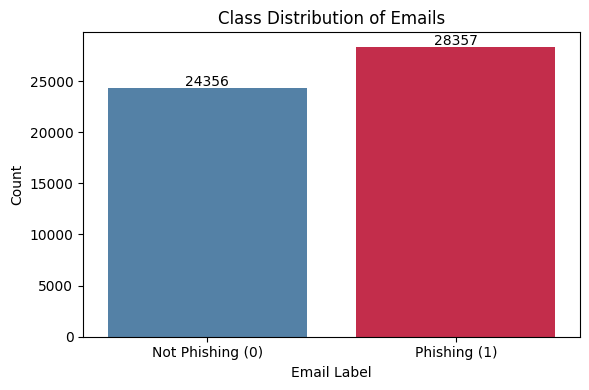

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', hue='label', palette={0: 'steelblue', 1: 'crimson'}, legend=False)
plt.xticks([0, 1], ['Not Phishing (0)', 'Phishing (1)'])
plt.title("Class Distribution of Emails")
plt.xlabel("Email Label")
plt.ylabel("Count")
for i, count in enumerate(df['label'].value_counts().sort_index()):
    plt.text(i, count + 200, str(count), ha='center')
plt.tight_layout()
plt.show()


## Logistic Regression - Pipeline 1 

Logistic (clean_text) Accuracy: 0.9854880015175946

 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      4926
           1       0.98      0.99      0.99      5617

    accuracy                           0.99     10543
   macro avg       0.99      0.99      0.99     10543
weighted avg       0.99      0.99      0.99     10543



<Figure size 600x500 with 0 Axes>

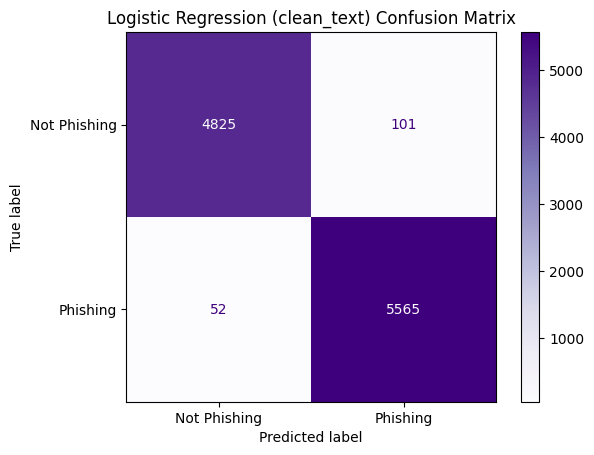

In [6]:
# === Logistic Regression: clean_text only ===
from sklearn.pipeline import Pipeline

# Step 1: Feature and label
X_text_only = df["clean_text"].fillna("unknown").astype(str)
y = df["label"]

# Step 2: Train/test split
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text_only, y, test_size=0.2, random_state=42
)

# Step 3: Build pipeline
logreg_text_only = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=1000)),
    ("clf", LogisticRegression(max_iter=2000))
])

# Step 4: Train
logreg_text_only.fit(X_train_text, y_train_text)

# Step 5: Predict and evaluate
y_pred_text = logreg_text_only.predict(X_test_text)
print("Logistic (clean_text) Accuracy:", accuracy_score(y_test_text, y_pred_text))
print("\n Classification Report:\n", classification_report(y_test_text, y_pred_text))

# Step 6: Confusion Matrix
cm_text = confusion_matrix(y_test_text, y_pred_text)
disp_text = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp_text.plot(cmap=plt.cm.Purples, values_format="d")
plt.title("Logistic Regression (clean_text) Confusion Matrix")
plt.grid(False)
plt.show()


## Logistic Regression - Pipeline 2

Logistic (processed_text) Accuracy: 0.9854880015175946

 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      4926
           1       0.98      0.99      0.99      5617

    accuracy                           0.99     10543
   macro avg       0.99      0.99      0.99     10543
weighted avg       0.99      0.99      0.99     10543



<Figure size 600x500 with 0 Axes>

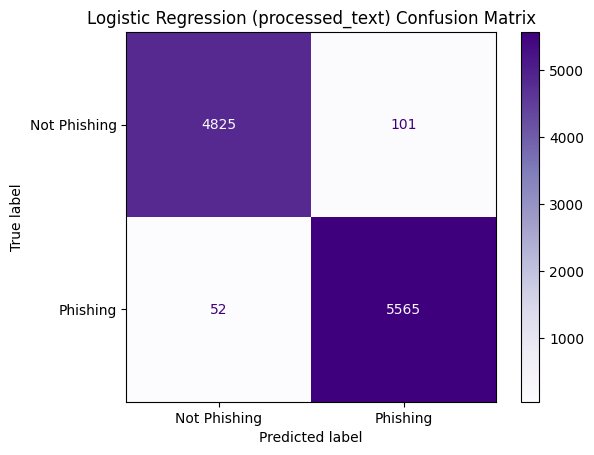

In [7]:
# === Logistic Regression: processed_text ===
from sklearn.pipeline import Pipeline

# Step 1: Feature and label
X_text_only = df["processed_text"].fillna("unknown").astype(str)
y = df["label"]

# Step 2: Train/test split
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text_only, y, test_size=0.2, random_state=42
)

# Step 3: Build pipeline
logreg_text_only = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=1000)),
    ("clf", LogisticRegression(max_iter=2000))
])

# Step 4: Train
logreg_text_only.fit(X_train_text, y_train_text)

# Step 5: Predict and evaluate
y_pred_text = logreg_text_only.predict(X_test_text)
print("Logistic (processed_text) Accuracy:", accuracy_score(y_test_text, y_pred_text))
print("\n Classification Report:\n", classification_report(y_test_text, y_pred_text))

# Step 6: Confusion Matrix
cm_text = confusion_matrix(y_test_text, y_pred_text)
disp_text = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp_text.plot(cmap=plt.cm.Purples, values_format="d")
plt.title("Logistic Regression (processed_text) Confusion Matrix")
plt.grid(False)
plt.show()


## Logistic Regression (full) - Pipeline 1 

Logistic full (clean_text) Accuracy: 0.9966802617850706

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      4926
           1       1.00      1.00      1.00      5617

    accuracy                           1.00     10543
   macro avg       1.00      1.00      1.00     10543
weighted avg       1.00      1.00      1.00     10543



<Figure size 600x500 with 0 Axes>

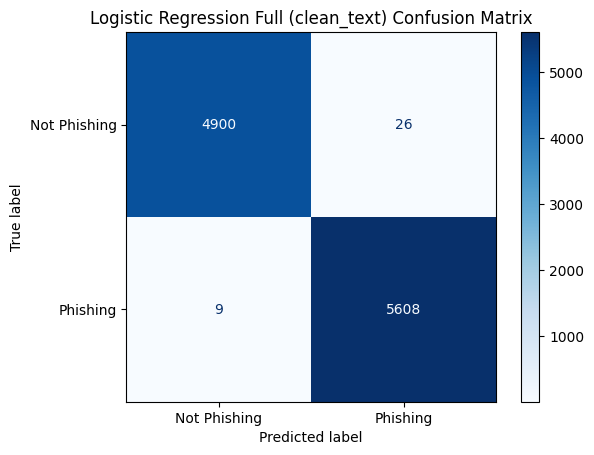

In [8]:
# === Step 1: Prepare data ===
# Make sure all text fields are strings
for col in ["clean_text", "sender", "receiver"]:
    df[col] = df[col].fillna("unknown").replace("", "unknown").astype(str)

# === Step 2: Select features and label ===
X = df[["clean_text", "sender", "receiver", "urls"]]  # urls stays as binary
y = df["label"]

# === Step 3: Build preprocessing pipeline ===
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=1000), "clean_text"),
        ("sender", TfidfVectorizer(max_features=100), "sender"),
        ("receiver", TfidfVectorizer(max_features=100), "receiver"),
    ],
    remainder="passthrough"  # keep 'urls' as is (numeric)
)

# === Step 4: Build and train the model ===
model = make_pipeline(preprocessor, LogisticRegression(max_iter=2000))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

# === Step 5: Evaluate ===
y_pred = model.predict(X_test)
print("Logistic full (clean_text) Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Logistic Regression Full (clean_text) Confusion Matrix")
plt.grid(False)
plt.show()


## Logistic Regression (full) - Pipeline 2

Logistic full (processed_text) Accuracy: 0.9967751114483544

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4926
           1       1.00      1.00      1.00      5617

    accuracy                           1.00     10543
   macro avg       1.00      1.00      1.00     10543
weighted avg       1.00      1.00      1.00     10543



<Figure size 600x500 with 0 Axes>

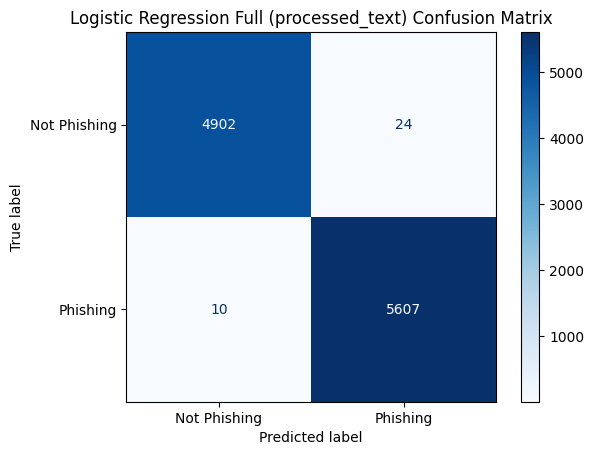

In [9]:
# === Step 1: Prepare data ===
# Make sure all text fields are strings
for col in ["processed_text", "sender", "receiver"]:
    df[col] = df[col].fillna("unknown").replace("", "unknown").astype(str)

# === Step 2: Select features and label ===
X = df[["processed_text", "sender", "receiver", "urls"]]  # urls stays as binary
y = df["label"]

# === Step 3: Build preprocessing pipeline ===
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=1000), "processed_text"),
        ("sender", TfidfVectorizer(max_features=100), "sender"),
        ("receiver", TfidfVectorizer(max_features=100), "receiver"),
    ],
    remainder="passthrough"  # keep 'urls' as is (numeric)
)

# === Step 4: Build and train the model ===
model = make_pipeline(preprocessor, LogisticRegression(max_iter=2000))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

# === Step 5: Evaluate ===
y_pred = model.predict(X_test)
print("Logistic full (processed_text) Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Logistic Regression Full (processed_text) Confusion Matrix")
plt.grid(False)
plt.show()


## Naive Bayes - Pipeline 1

Naive Bayes (clean_text) Accuracy: 0.9539979133074078

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      4926
           1       0.95      0.97      0.96      5617

    accuracy                           0.95     10543
   macro avg       0.95      0.95      0.95     10543
weighted avg       0.95      0.95      0.95     10543



<Figure size 600x500 with 0 Axes>

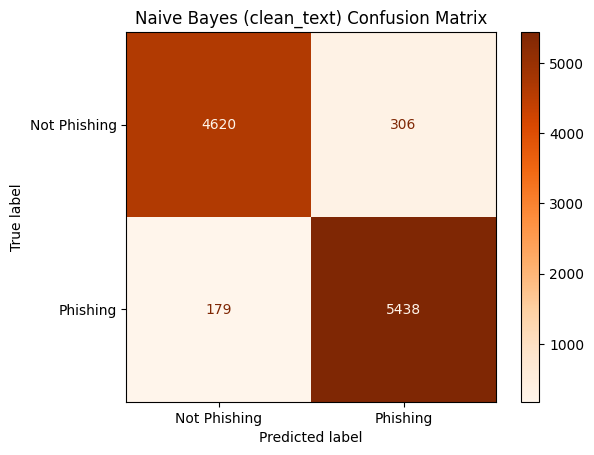

In [10]:
# === Step 1: Make sure 'clean_text' and 'label' are ready ===
df["clean_text"] = df["clean_text"].fillna("unknown").astype(str)
X_text = df["clean_text"]
y = df["label"]

# === Step 2: Split data ===
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

# === Step 3: Naive Bayes pipeline ===
nb_model = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=1000)),
    ("clf", MultinomialNB())
])

# === Step 4: Train and predict ===
nb_model.fit(X_train_text, y_train)
y_pred_nb = nb_model.predict(X_test_text)

# === Step 5: Evaluation ===
print("Naive Bayes (clean_text) Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Oranges, values_format="d")
plt.title("Naive Bayes (clean_text) Confusion Matrix")
plt.grid(False)
plt.show()


## Naive Bayes - Pipeline 2

Naive Bayes (processed_text) Accuracy: 0.9552309589300958

 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      4926
           1       0.95      0.97      0.96      5617

    accuracy                           0.96     10543
   macro avg       0.96      0.95      0.95     10543
weighted avg       0.96      0.96      0.96     10543



<Figure size 600x500 with 0 Axes>

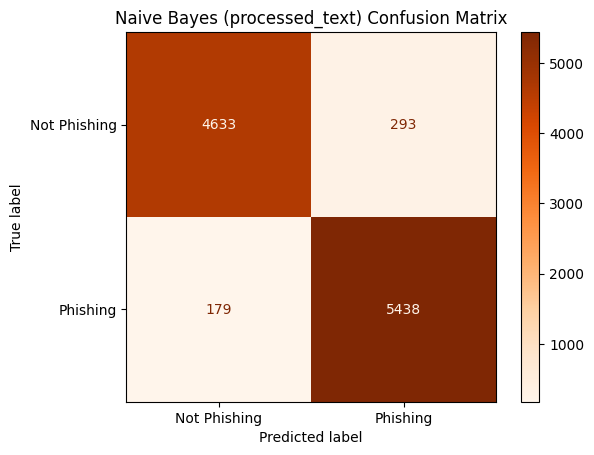

In [11]:
# === Step 1: Make sure 'processed_text' and 'label' are ready ===
df["processed_text"] = df["processed_text"].fillna("unknown").astype(str)
X_text = df["processed_text"]
y = df["label"]

# === Step 2: Split data ===
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

# === Step 3: Naive Bayes pipeline ===
nb_model = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=1000)),
    ("clf", MultinomialNB())
])

# === Step 4: Train and predict ===
nb_model.fit(X_train_text, y_train)
y_pred_nb = nb_model.predict(X_test_text)

# === Step 5: Evaluation ===
print("Naive Bayes (processed_text) Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\n Classification Report:\n", classification_report(y_test, y_pred_nb))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Oranges, values_format="d")
plt.title("Naive Bayes (processed_text) Confusion Matrix")
plt.grid(False)
plt.show()


## XGBoost - Pipeline 1

/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:06:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (clean_text) Accuracy: 0.9930759745802903

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4926
           1       0.99      1.00      0.99      5617

    accuracy                           0.99     10543
   macro avg       0.99      0.99      0.99     10543
weighted avg       0.99      0.99      0.99     10543



<Figure size 600x500 with 0 Axes>

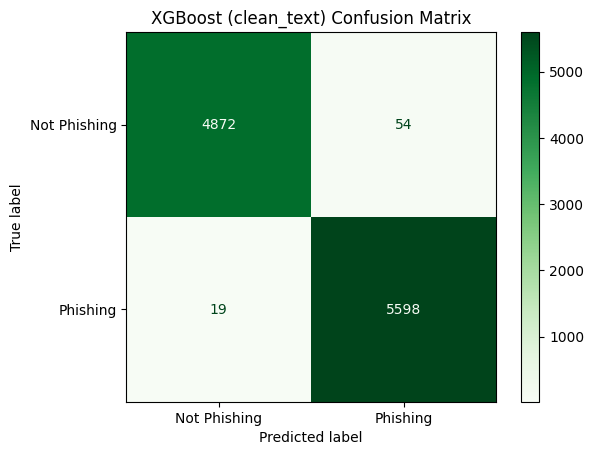

In [12]:
# === Step 1: Load and prepare dataset ===
df["clean_text"] = df["clean_text"].fillna("unknown").astype(str)
y = df["label"]

# === Step 2: TF-IDF vectorization on clean_text only ===
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df["clean_text"])

# === Step 3: Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

# === Step 4: Train XGBoost model ===
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# === Step 5: Predict and evaluate ===
y_pred = xgb_model.predict(X_test)

print("XGBoost (clean_text) Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Greens, values_format="d")
plt.title("XGBoost (clean_text) Confusion Matrix")
plt.grid(False)
plt.show()


## XGBoost - Pipeline 2

/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:06:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (processed_text) Accuracy: 0.9924120269373043

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4926
           1       0.99      1.00      0.99      5617

    accuracy                           0.99     10543
   macro avg       0.99      0.99      0.99     10543
weighted avg       0.99      0.99      0.99     10543



<Figure size 600x500 with 0 Axes>

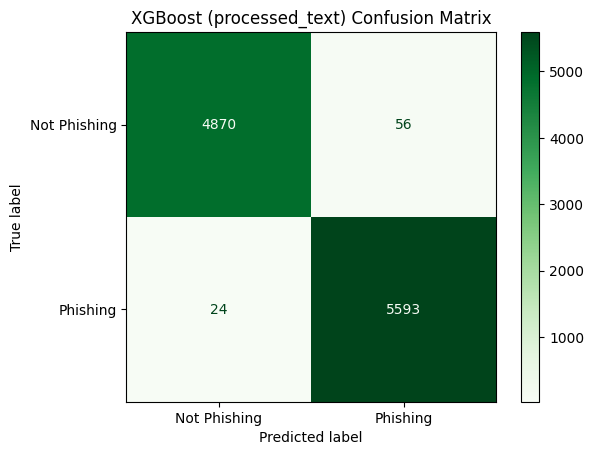

In [13]:
# === Step 1: Load and prepare dataset ===

df["processed_text"] = df["processed_text"].fillna("unknown").astype(str)
y = df["label"]

# === Step 2: TF-IDF vectorization on processed_text ===
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df["processed_text"])

# === Step 3: Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

# === Step 4: Train XGBoost model ===
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# === Step 5: Predict and evaluate ===
y_pred = xgb_model.predict(X_test)

print("XGBoost (processed_text) Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Greens, values_format="d")
plt.title("XGBoost (processed_text) Confusion Matrix")
plt.grid(False)
plt.show()


## XGBoost (full) - Pipeline 1

/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:07:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Full (clean_text) Accuracy: 0.9975339087546239

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4926
           1       1.00      1.00      1.00      5617

    accuracy                           1.00     10543
   macro avg       1.00      1.00      1.00     10543
weighted avg       1.00      1.00      1.00     10543



<Figure size 600x500 with 0 Axes>

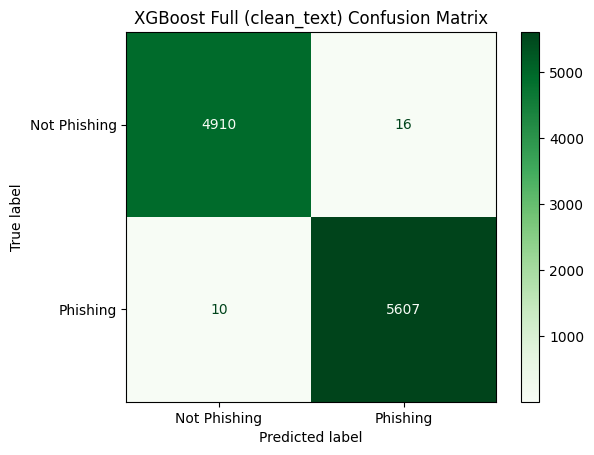

In [14]:
# === Step 1: Preprocessing ===
for col in ["clean_text", "sender", "receiver"]:
    df[col] = df[col].fillna("unknown").astype(str)

# Features & labels
X = df[["clean_text", "sender", "receiver", "urls"]]
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Step 2: Vectorize text columns ===
tfidf_text = TfidfVectorizer(max_features=1000)
tfidf_sender = TfidfVectorizer(max_features=100)
tfidf_receiver = TfidfVectorizer(max_features=100)

X_train_text = tfidf_text.fit_transform(X_train["clean_text"])
X_test_text = tfidf_text.transform(X_test["clean_text"])

X_train_sender = tfidf_sender.fit_transform(X_train["sender"])
X_test_sender = tfidf_sender.transform(X_test["sender"])

X_train_receiver = tfidf_receiver.fit_transform(X_train["receiver"])
X_test_receiver = tfidf_receiver.transform(X_test["receiver"])

# urls is already numeric
X_train_urls = X_train["urls"].values.reshape(-1, 1)
X_test_urls = X_test["urls"].values.reshape(-1, 1)

# === Step 3: Combine all features ===
X_train_combined = hstack([X_train_text, X_train_sender, X_train_receiver, X_train_urls])
X_test_combined = hstack([X_test_text, X_test_sender, X_test_receiver, X_test_urls])

# === Step 4: Train XGBoost ===
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train_combined, y_train)

# === Step 5: Predict & evaluate ===
y_pred_xgb = xgb_model.predict(X_test_combined)
print("XGBoost Full (clean_text) Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\n Classification Report:\n", classification_report(y_test, y_pred_xgb))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Greens, values_format="d")
plt.title("XGBoost Full (clean_text) Confusion Matrix")
plt.grid(False)
plt.show()


## XGBoost (full) - Pipeline 2

/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [06:07:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Full (processed_text) Accuracy: 0.997818457744475

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4926
           1       1.00      1.00      1.00      5617

    accuracy                           1.00     10543
   macro avg       1.00      1.00      1.00     10543
weighted avg       1.00      1.00      1.00     10543



<Figure size 600x500 with 0 Axes>

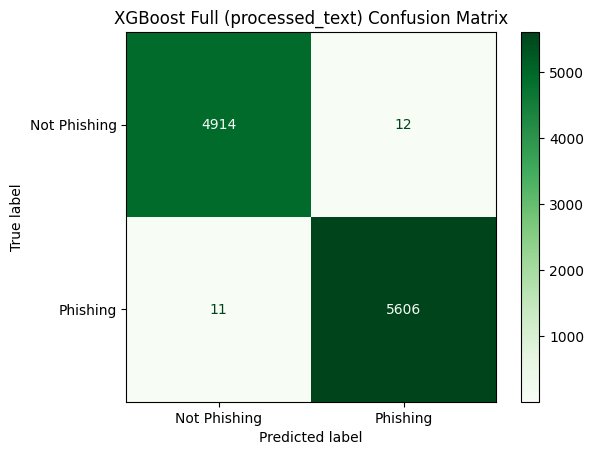

In [15]:
# === Step 1: Preprocessing ===
for col in ["processed_text", "sender", "receiver"]:
    df[col] = df[col].fillna("unknown").astype(str)

# Features & labels
X = df[["processed_text", "sender", "receiver", "urls"]]
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Step 2: Vectorize text columns ===
tfidf_text = TfidfVectorizer(max_features=1000)
tfidf_sender = TfidfVectorizer(max_features=100)
tfidf_receiver = TfidfVectorizer(max_features=100)

X_train_text = tfidf_text.fit_transform(X_train["processed_text"])
X_test_text = tfidf_text.transform(X_test["processed_text"])

X_train_sender = tfidf_sender.fit_transform(X_train["sender"])
X_test_sender = tfidf_sender.transform(X_test["sender"])

X_train_receiver = tfidf_receiver.fit_transform(X_train["receiver"])
X_test_receiver = tfidf_receiver.transform(X_test["receiver"])

# urls is already numeric
X_train_urls = X_train["urls"].values.reshape(-1, 1)
X_test_urls = X_test["urls"].values.reshape(-1, 1)

# === Step 3: Combine all features ===
X_train_combined = hstack([X_train_text, X_train_sender, X_train_receiver, X_train_urls])
X_test_combined = hstack([X_test_text, X_test_sender, X_test_receiver, X_test_urls])

# === Step 4: Train XGBoost ===
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train_combined, y_train)

# === Step 5: Predict & evaluate ===
y_pred_xgb = xgb_model.predict(X_test_combined)
print("XGBoost Full (processed_text) Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\n Classification Report:\n", classification_report(y_test, y_pred_xgb))

# === Step 6: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Greens, values_format="d")
plt.title("XGBoost Full (processed_text) Confusion Matrix")
plt.grid(False)
plt.show()
